# **Inverted Pendulum LQR controller**

We consider a simple linearized version of the system assuming $\theta(t)$ and $\dot{\theta}(t)$ are very small. 

<p align="center">
    <img width=400 src="images/pendulum.svg">
</p>


[Image Source ](https://en.wikipedia.org/wiki/Inverted_pendulum#/media/File:Cart-pendulum.svg)

Consider a cart with an inverted pendulum hinged on top of it as shown in the figure. For simplicity, the cart and the pendulum are assumed to move in only one plane, and the friction, the mass of the stick, and the gust of wind are disregarded. The problem is to maintain the pendulum at the vertical position. For example, if the inverted pendulum is falling in the direction shown, the cart moves to the right and exerts a force, through the hinge, to push the pendulum back to the vertical position.
Let's consider the linearized inverted pendulum system (assuming $\theta(t)$ and $\dot{\theta}(t)$ are very small)

\begin{equation}
\begin{bmatrix}
    \dot{x}_1(t) \\ \dot{x}_3(t) \\ \dot{x}_3(t) \\  \dot{x}_4(t) \\ 
\end{bmatrix}
=
\begin{bmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & -\frac{mg}{M} & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & \frac{(M+m)g}{Ml} & 0 
\end{bmatrix}
\begin{bmatrix}
    x_1(t) \\ x_2(t) \\ x_3(t) \\ x_4(t)
\end{bmatrix}
+
\begin{bmatrix}
    0 \\ \frac{1}{M} \\ 0 \\ - \frac{1}{Ml}
\end{bmatrix}
u(t)
\end{equation}

where $x_1(t) = x(t), \; x_2(t) = \dot{x}(t), \; x_3(t) = \theta(t), \; and \; x_4(t) = \dot{\theta}(t)$
Consider the LQR problem

\begin{align}
    &u^* := argmin_{u:[0,\infty) \to \mathbb{R}^m} J(u) := \int_0^\infty \left( x(t)^T Qx(t) + u(t)^T R u(t) \right) dt \\
    &\text{subject to}\\
    &\dot{x}(t) = Ax(t) + Bu(t), \; x(0) = x_0
\end{align}

where $A$ and $B$ are appropriate system matrices with $m=1, M=2, l=3$ and $g=9.8$.

**Tasks**

1. Appropriately choose the weighting $Q \geq 0$ and $R > 0$ to maintain the pendulum at the vertical position, i.e., $\theta(t) = 0$ and $\dot{\theta}(t) = 0$ as much as possible.
2. Find an optimal policy for the LQR problem using Python or Matlab functions.
3. Plot trajectories of the system x(t) and the control input u(t) over certain time interval to demonstrate the performance of your optimal control policy.
4. In the answer, please include your Python or Matlab codes.

Change the weight and see how the performance changes and discuss about the results.

## LQR controller in Python

We use Python because of:
- Totally open source environment
- More suitable to research

In [1]:
import numpy as np
import torch
import scipy.linalg
 
def LQR(A,B,Q,R):
    """Solve the continuous time lqr controller.

    dx/dt = A x + B u

    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals
 
def dLQR(A,B,Q,R):
    """Solve the discrete time lqr controller.

    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    return K, X, eigVals

## System definition

We define the system with matrices (with numpy first to solve with scipy)

In [2]:
# Parameters
m = 1 # pendulum mass
M = 2 # cart mass
l = 3 # pendulum length
g = 9.8 # gravity acceleration

# Build matrices
A = np.array([[0, 1, 0, 0], [0, 0, -m*g/M, 0], [0, 0, 0, 1], [0, 0, (M+m)*g/(M*l), 0]])
B = np.array([[0], [1/M], [0], [-1/(M*l)]])
print('A:\n', A)
print('B:\n', B)

A:
 [[ 0.   1.   0.   0. ]
 [ 0.   0.  -4.9  0. ]
 [ 0.   0.   0.   1. ]
 [ 0.   0.   4.9  0. ]]
B:
 [[ 0.        ]
 [ 0.5       ]
 [ 0.        ]
 [-0.16666667]]


Choose $Q$ and $R$ matrices. Simplest choice: $Q = I$, $R = \rho I$. The larger the R value, the least energy we are using.

The values on the diagonal of the $Q$ matrix act as "penalties" for the corresponding state i.e. we want the $\theta, \dot{\theta}$ as small as possible hence they have a greater penalty.

In [138]:
# Choose Q and R matrices for control (trial and error)
rho = 0.1
Q = np.matrix([
    [100, 0, 0,   0],
    [0, 100, 0,   0],
    [0, 0, 100, 0],
    [0, 0, 0, 100]])
R = rho * np.eye(1) # control size is 1
print('Q:\n', Q)
print('R:\n', R)

Q:
 [[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
R:
 [[0.1]]


In [128]:
import time
start = time.time()
for i in range(1000):
    K, X, eigVals = LQR(A, B, Q, R)
end = time.time()
print(end-start, "seconds")

print(('K = {}\n').format(K))
print(('X = {}\n').format(X))
print(('Eigenvalues = {}\n').format(eigVals))

1.1198229789733887 seconds
K = [[ -31.6227766   -69.00397721 -612.25803618 -334.32523211]]

X = [[  218.2097356    188.07744356  1057.22921272   583.20599663]
 [  188.07744356   302.5227604   1723.77107316   948.97066753]
 [ 1057.22921272  1723.77107316 10186.50228128  5538.66804117]
 [  583.20599663   948.97066753  5538.66804117  3047.50714186]]

Eigenvalues = [-16.75527625+0.j          -1.72883424+0.27491166j
  -1.72883424-0.27491166j  -1.00593868+0.j        ]



In [139]:
import math

class ControlledPendulum():
    '''Continuous version of the OpenAI Gym cartpole
    Inspired by: https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8
    GOAL: decouple from openAI Gym'''
    def __init__(self, M, m, l, tau=0.02, g=9.81):
        self.gravity = g
        self.masscart = M
        self.masspole = m
        self.total_mass = (self.masspole + self.masscart)
        self.length = l  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = tau  # seconds between state updates
        self.state = None # Initialize through reset
        
    def step(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        self.state = x, x_dot, theta, theta_dot # save state
        return np.array(self.state, dtype='float64').reshape(4,1)

    def reset(self, x_initial= [1, 0, 0, 0], random=False):
        if random == True:
            self.state = np.random.uniform(-0.1, 0.1, size=4)
        else:
            self.state = x_initial
        return np.array(self.state, dtype='float64').reshape(4,1)

In [140]:
model = ControlledPendulum(M, m, l, g=9.8)
# Initial condition
x0 = [1, 0, 0, 0] # Start from position 1 meters. The goal is to reach 0 in this case
model.reset(x_initial=x0, random=True)

array([[-0.09889335],
       [ 0.01327392],
       [ 0.09119826],
       [-0.07637344]])

In [54]:
# Input check
model.step(np.array([[1]]))

array([[ 0.0303033 ],
       [-0.03044415],
       [ 0.06581482],
       [-0.03396493]])

Now we can plug in the control input. The optimal control input is given by $u^*(t) = -K x$ where $K$ is the gain we have previously found and $x$ is the current state. 

In [131]:
# x is the state space
x0 = [-1, 0, 0, 0] # Start from position -0.5 meters. The goal is to reach 0 in this case
x = model.reset(x_initial=x0, random=False)

# Save trajectory for the graph
trajectory = []
controls = []

# Control loop
for i in range(500):
    u = - K.dot(x)  # the control input is u* = -Kx
    x = model.step(u) # propagate
    trajectory.append(x)
    controls.append(u)

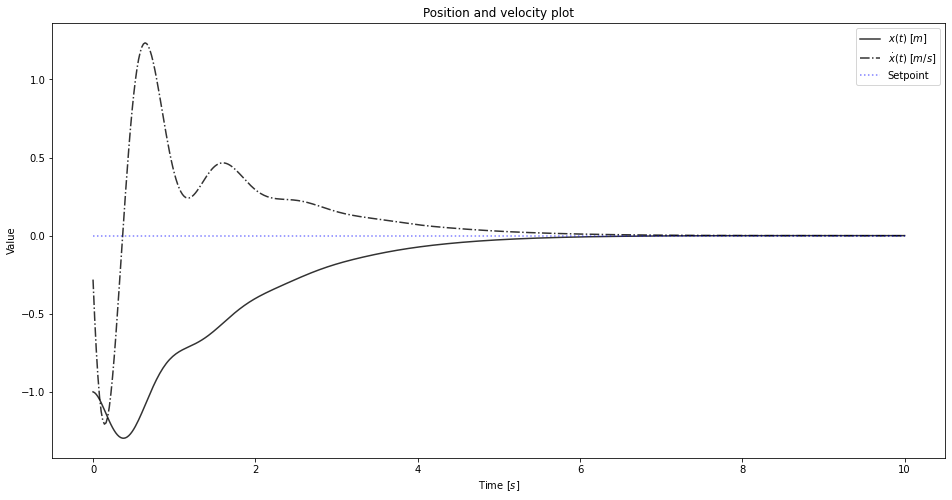

In [141]:
# Trajectory plotting
import matplotlib.pyplot as plt

tau = 0.02 # time of system update
tot_time = tau*len(trajectory)
t = np.linspace(0, tot_time, len(trajectory)) # time

x_traj, xdot_traj, theta_traj, thetadot_traj, ctrl_traj = [], [], [], [], []
for i in range(len(trajectory)):
    x_traj.append(trajectory[i][0][0])
    xdot_traj.append(trajectory[i][1][0])
    theta_traj.append(trajectory[i][2][0])
    thetadot_traj.append(trajectory[i][3][0])
    ctrl_traj.append(controls[i][0][0].item())
    
fig, ax = plt.subplots(1,1, figsize=(16, 8))
ax.plot(t, x_traj, "k", alpha=.8, label=r'$x(t)$ [$m$]')
ax.plot(t, xdot_traj, "-.k", alpha=.8, label=r'$\dot{x}(t)$ [$m/s$]')
ax.plot([0, tot_time], [0, 0], ":b", alpha=.5, label=r'Setpoint')
ax.legend(loc='upper right')
ax.set_xlabel(r'Time [$s$]')
ax.set_ylabel(r'Value')
ax.set_title("Position and velocity plot")
fig.savefig('images/pendulum_pos_vel.jpg')

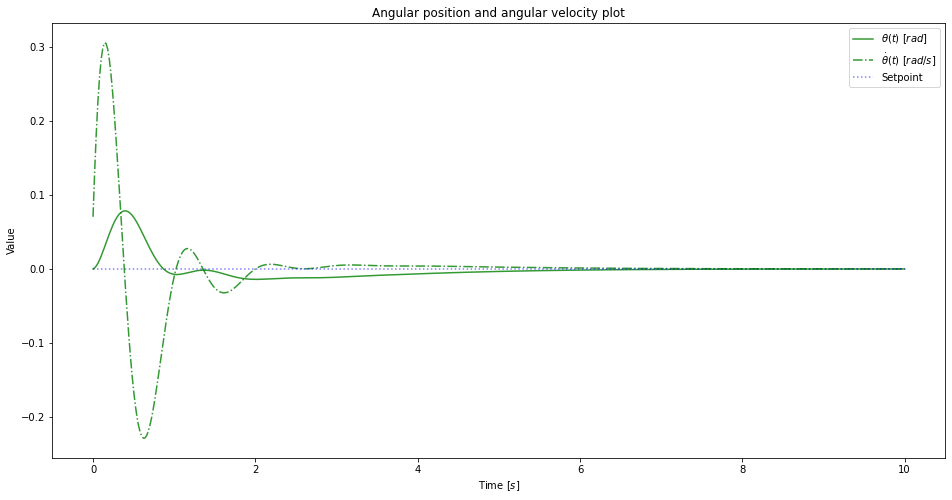

In [142]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
ax.plot(t, theta_traj, "g", alpha=.8,label=r'$ \theta (t)$ [$rad$]')
ax.plot(t, thetadot_traj, "-.g", alpha=.8,label=r'$\dot{ \theta }(t)$ [$rad/s$]')
ax.plot([0, tot_time], [0, 0], ":b", alpha=.5, label=r'Setpoint')
ax.legend(loc='upper right')
ax.set_xlabel(r'Time [$s$]')
ax.set_ylabel(r'Value')
ax.set_title("Angular position and angular velocity plot")
fig.savefig('images/pendulum_angular_pos_vel.jpg')

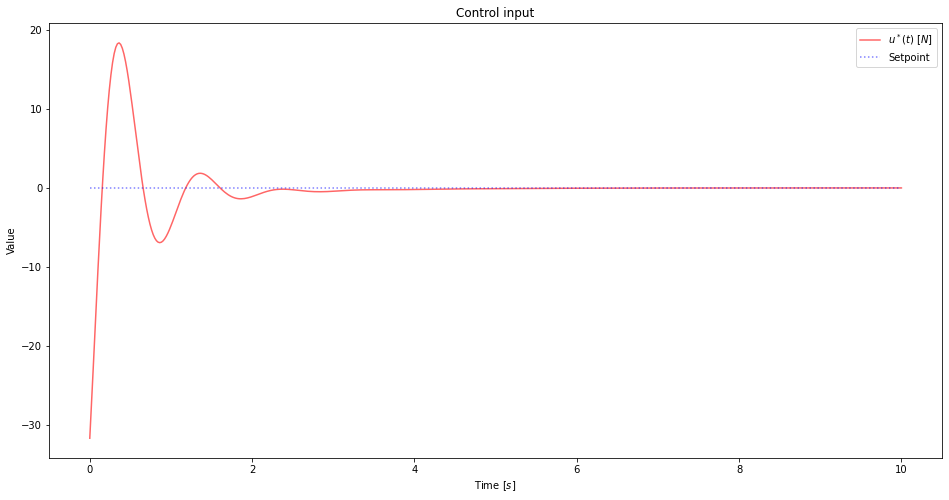

In [143]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
ax.plot(t, ctrl_traj, "r", alpha=.6,label=r'$ u^*(t)$ [$N$]')
ax.plot([0, tot_time], [0, 0], ":b", alpha=.5, label=r'Setpoint')
ax.legend(loc='upper right')
ax.set_xlabel(r'Time [$s$]')
ax.set_ylabel(r'Value')
ax.set_title("Control input")
fig.savefig('images/pendulum_input.jpg')